In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image
import numpy as np
from tqdm import tqdm
from torchvision import transforms, datasets
import torch.optim as optim
import torch.utils.data as data
import os
from PIL import Image
from __future__ import annotations

In [4]:
# import pandas as pd
# dataset = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/seq2seq/data/total.csv")
# dataset = list(zip(dataset['KOR'], dataset['ENG']))[:10]
# print(dataset.__len__())

In [5]:
class EncoderRNN(nn.Module):
  def __init__(self, hidden_size: int = 256):
    super().__init__()
    self.hidden_size = hidden_size
    self.attan = nn.Linear(256, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)

  def forward(self, input):
    x = self.attan(input)
    return self.gru(x)

In [6]:
class CharRNNNetwork(nn.Module):
  def __init__(self, hidden_size: int = 256, max_length: int = 256, dropout: float = .2):
    super().__init__()
    self.attan = nn.Linear(256, hidden_size)
    self.dropout = nn.Dropout(dropout)
    self.attan2 = nn.Linear(hidden_size << 1, hidden_size)
    self.attan3 = nn.Linear(hidden_size << 1, hidden_size)
    self.gru = nn.GRU(hidden_size, hidden_size)
    self.out = nn.Linear(hidden_size, 256)
    self.hidden_size = hidden_size

  def forward(self, input, hidden, encoder_hidden):
    """
    encoder_outputs = [size, max_length, hidden_size]
    """
    x = self.attan(input)
    x = self.dropout(x)
    weights = F.softmax(torch.cat((x[0], encoder_hidden[0]), dim = 1), dim = 1)
    weights = self.attan2(weights)
    x = torch.cat((x[0], weights), dim = 1)
    x = self.attan3(x).unsqueeze(0)
    x = F.relu(x)
    x, hidden = self.gru(x, hidden)
    x = self.out(x[0])
    x = F.log_softmax(x, dim = 1)
    return x, hidden, weights

In [7]:
dataset = [
    ["Hello", "Hi"],
    ["I", "My"],
    ["I am", "I m"],
    ["Thankyou", "Thankyou!"],
    ["test code", "Test code"],
    ["It's work", "It is work"],
    ["He is", "He s"],
    ["he is", "he s"],
    ["He s", "He's"],
    ["he is", "he's"],
    ["you re", "you're"],
    ["She is", "She s"],
    ["she is", "she s"],
    ["She s", "She's"],
    ["she s", "she's"],
    ["You re", "You're"],
    ["I m", "I'm"],
    ["hello", "hi"],
    ["you are", "you re"],
    ["You are", "You re"],
    ["laugh of loud", "lol"],
    ["How are you", "H r u"],
    ["how are you", "h r u"],
    ["we are", "we re"],
    ["they are", "they re"],
    ["They are", "They re"],
    ["He's", "He is"],
    ["That is right", "That's right"],
    ["I am fine", "I m fine"],
    ["안녕하세요", "안녕"],
    ["반갑습니다", "반가워"],
    ["반가워요", "반가워"],
    ["안녕하십니까?", "안녕?"],
    ["안녕하세요?", "안녕?"],
    ["아버지가방에들어가신다", "아버지가 방에 들어가신다"],
    ["아기다리고기다리던여름방학", "아 기다리고 기다리던 여름방학"],
    ["인간", "사람"],
    ["ezreal", "is real"],
    ["lol", "laugh of loud"],
    ["hi", "hello"],
    ["h r u", "how are you"],
    ["H r u", "How are you"],
    ["LOL", "Laugh Of Loud"],
    ["What's your name?", "What is your name?"],
    ["what's your name?", "what is your name?"],
    ["What is your name?", "What's your name?"],
    ["what is your name?", "what's your name?"],
    ["How are you?", "H r u?"],
    ["Where is your cell phone?", "Where's your cell phone?"],
    ["where is your cell phone?", "where's your cell phone?"],
    ["That's right!", "That is right!"],
    ["that's right!", "that is right"],
    ["안녕하세요? 반갑습니다", "안녕? 반가워"],
]

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
encoder = EncoderRNN().to(device)
decoder = CharRNNNetwork().to(device)
print(device)

cuda


In [35]:
def str2tensor(s):
  data = torch.zeros(s.__len__(), 4, 256)
  for i, c in enumerate(s):
    c = ord(c)
    for j in range(4):
      data[i, j, c & 255] = 1
      c = c >> 8

  return data

In [36]:
def char2tensor(c):
  data = torch.zeros(1, 4, 256)
  if c.__len__() <= 0:
    return data
  c = ord(c)
  for i in range(4):
    data[0, i, c & 255] = 1.0
    c = c >> 8
  return data

In [37]:
def char2idx_tensor(c):
  data = torch.zeros(1, 4, dtype=torch.long)
  if c.__len__() <= 0:
    return data

  c = ord(c)
  for i in range(4):
    data[0, i] = c & 255
    c = c >> 8
  return data

In [38]:
def idx_tensor2number(arr: torch.Tensor):
  arr = arr.squeeze(0)
  c = 0
  for i in range(3, -1, -1):
    c = c << 8
    c = c | arr[i]

  return c.item()

In [39]:
chr(idx_tensor2number(char2idx_tensor('a')))

'a'

In [40]:
def show_plot(points):
  plt.figure()
  plt.plot(points)

In [41]:
def get_loss(criterion, x, y):
  encoder_output, encoder_hidden = encoder(str2tensor(x).to(device))

  decoder_input = torch.zeros(1, 4, 256, device=device)
  decoder_hidden = encoder_hidden

  loss = 0

  use_teacher_forcing = torch.rand(1)[0] < .5

  if use_teacher_forcing:
    for i in range(y.__len__()):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hidden)
      loss += criterion(decoder_output, char2idx_tensor(y[i])[0].to(device))
      decoder_input = char2tensor(y[i]).to(device)

  else:
    for i in range(y.__len__() + 1):
      decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hidden)
      loss += criterion(decoder_output, char2idx_tensor(y[i] if i < y.__len__() else '')[0].to(device))
  return loss

In [42]:
def train(epochs: int = 10):
  encoder_optimizer = optim.Adam(encoder.parameters(), lr=1e-3)
  decoder_optimizer = optim.Adam(decoder.parameters(), lr=1e-3)
  criterion = nn.NLLLoss()

  losses = []

  for epoch in range(epochs):
    loss_avg = 0
    for i, (x, y) in enumerate(dataset):
      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      loss = get_loss(criterion, x, y)
      # loss += get_loss(criterion, y, x)

      loss.backward()

      encoder_optimizer.step()
      decoder_optimizer.step()

      loss_avg += (loss.item() - loss_avg) / (i + 1)

    losses.append(loss_avg)
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == epochs - 1:
      print("[{}/{}] Loss: {:.6F}".format(epoch + 1, epochs, loss_avg))

  show_plot(losses)


[1/400] Loss: 15.429452
[10/400] Loss: 6.275833
[20/400] Loss: 3.428903
[30/400] Loss: 2.325230
[40/400] Loss: 0.976354
[50/400] Loss: 0.933862
[60/400] Loss: 1.125906
[70/400] Loss: 0.840257
[80/400] Loss: 0.939651
[90/400] Loss: 1.018905
[100/400] Loss: 0.473646
[110/400] Loss: 0.107988
[120/400] Loss: 0.141812
[130/400] Loss: 0.111171
[140/400] Loss: 0.053485
[150/400] Loss: 0.310863
[160/400] Loss: 0.026416
[170/400] Loss: 0.028490
[180/400] Loss: 0.019821
[190/400] Loss: 0.017868
[200/400] Loss: 0.012525
[210/400] Loss: 0.011002
[220/400] Loss: 0.009669
[230/400] Loss: 0.010239
[240/400] Loss: 0.008813
[250/400] Loss: 0.009002
[260/400] Loss: 0.008737
[270/400] Loss: 0.007754
[280/400] Loss: 0.006810
[290/400] Loss: 0.008398
[300/400] Loss: 0.007017
[310/400] Loss: 0.008075
[320/400] Loss: 0.007692
[330/400] Loss: 0.007779
[340/400] Loss: 0.007800
[350/400] Loss: 0.007698
[360/400] Loss: 0.007158
[370/400] Loss: 0.853086
[380/400] Loss: 0.158056
[390/400] Loss: 0.038247
[400/400] 

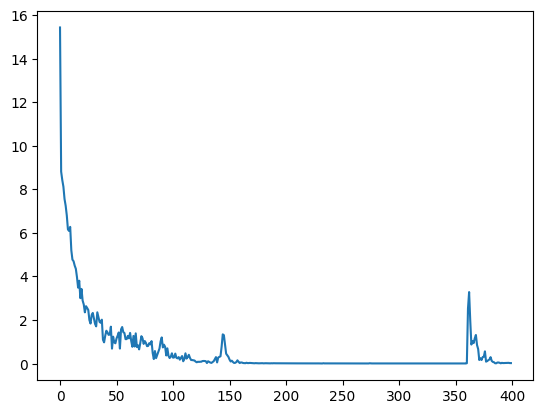

In [43]:
train(epochs = 400)

In [44]:
torch.save({
    'model_state': encoder.state_dict()
}, '/gdrive/MyDrive/Colab Notebooks/seq2seq/models/encoder.pt')

torch.save({
    'model_state': decoder.state_dict()
}, '/gdrive/MyDrive/Colab Notebooks/seq2seq/models/decoder.pt')

In [45]:
@torch.inference_mode()
def evaluate(s, max_length: int = 512):
  encoder_output, encoder_hidden = encoder(str2tensor(s).to(device))

  decoder_input = torch.zeros(1, 4, 256, device = device)
  decoder_hidden = encoder_hidden

  decoded_chars = []
  decoded_attensions = torch.zeros(max_length, decoder.hidden_size)

  for i in range(max_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_hidden)
    decoded_number = idx_tensor2number(decoder_output.argmax(1))
    decoded_attensions[i] = decoder_attention.max(0).values
    if decoded_number <= 0 or decoded_number > 0x10FFFF:
      decoded_chars.append('<EOS>')
      break

    decoded_chars.append(chr(decoded_number))

  return decoded_chars, decoded_attensions[:i + 1]

In [46]:
def show_attention(sentence, output_chars, attentions):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(attentions.detach().numpy(), cmap='bone')
  fig.colorbar(cax)

  ax.set_xticklabels([''] + list(sentence))
  ax.set_yticklabels([''] + output_chars)
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()


def evalute_and_show(sentence: str):
  output_chars, attentions = evaluate(sentence)
  print('input = ', sentence)
  print('output = ', ''.join(output_chars))
  # show_attention(sentence, output_chars, attentions)

In [47]:
evalute_and_show("안녕하세요")
evalute_and_show("테스트")
evalute_and_show("반가워")
evalute_and_show("한국어")
evalute_and_show("영어")
evalute_and_show("3000")
evalute_and_show("이번 시험 혹시 범위가 어떻게 되는지 아세요? 제가 지난주 수업을 못가서요.")

input =  안녕하세요
output =  안녕<EOS>
input =  테스트
output =  䥌⁡ふi걩 †くf가l<EOS>
input =  반가워
output =  반가였<EOS>
input =  한국어
output =  桉††楩ai<EOS>
input =  영어
output =  ᡉ 0 뱧s y뤀뱵<EOS>
input =  3000
output =  D 0ä¬à 0ä¬X ì)Y<EOS>
input =  이번 시험 혹시 범위가 어떻게 되는지 아세요? 제가 지난주 수업을 못가서요.
output =  암녨at밠견였 됡씀<EOS>


In [48]:
evalute_and_show("안녕하세요")
evalute_and_show("hi")
evalute_and_show("반가워")
evalute_and_show("She is")
evalute_and_show("She is my friend")
evalute_and_show("What's your name?")

input =  안녕하세요
output =  안녕<EOS>
input =  hi
output =  hello<EOS>
input =  반가워
output =  반가였<EOS>
input =  She is
output =  She s<EOS>
input =  She is my friend
output =  lhl<EOS>
input =  What's your name?
output =  What is your name?<EOS>
